In [1]:
import json
import sklearn
import requests
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import json
import matplotlib.pyplot as plt
import time

In [2]:
with open("./zenodo_open_metadata_06_04_2017.json", "r") as fp:
    data = json.load(fp)
spams = [17229, 400865, 19031, 285825, 440002, 292995, 221828, 18818, 160518, 32519, 437895, 22211, 290571, 438157, 44942, 33550, 246800, 51728, 398866, 400531, 60051, 50704, 32918, 164886, 164888, 495001, 165784, 34331, 321818, 60828, 346531, 399268, 18045, 27942, 35364, 30632, 202291, 47155, 293045, 47286, 290359, 224947, 29113, 375738, 20539, 17596, 293053, 439998, 439997, 290237, 49089, 440001, 440003, 440004, 440005, 440006, 440007, 154696, 440009, 440008, 290123, 35276, 284358, 398797, 32076, 33365, 249942, 290134, 344537, 166752, 291812, 18281, 46445, 51054, 290685, 34287, 28271, 439999, 232944, 290157, 23155, 290166, 440000, 249981]
maybe_spams = [153959, 12846, 13138, 13385, 398764, 400012]
for d in data:
    if d['recid'] in (spams + maybe_spams):
        d['spam'] = True
labels = [d['spam'] for d in data]

In [3]:
def feat_tr(d):
    return d['description'] + d['title']

X = [feat_tr(d) for d in data]
y = np.array([[1 if d['spam'] else 0, 1 if not d['spam'] else 0] for d in data])

ngram_range=(1, 1)
count_vect = CountVectorizer(ngram_range=ngram_range, max_features=8000)
tfid = TfidfTransformer()
X_v = count_vect.fit_transform(X)
X_v = tfid.fit_transform(X_v)
trainX, testX, trainY, testY = train_test_split(X_v, np.asarray(y, dtype=np.float32), test_size=0.33, random_state=42)
#trainX, testX, trainY, testY = train_test_split(X_v, np.asarray(y, dtype=np.float32), test_size=30000, train_size=60000, random_state=42)

In [22]:
trX_idx, tsX_idx, trY_idx, tsY_idx = train_test_split(range(X_v.shape[0]),range(X_v.shape[0]), test_size=0.33, random_state=42)

In [4]:
trainX = np.asarray(trainX.todense(), dtype=np.float32)
#trainY = trainY
testX = np.asarray(testX.todense(), dtype=np.float32)
#testY = testY

In [5]:
trainY.shape

(123278, 2)

In [6]:
numFeatures = trainX.shape[1]
numLabels = trainY.shape[1]
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [7]:
# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
Xtens = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [8]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

In [9]:
# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(Xtens, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

In [11]:
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

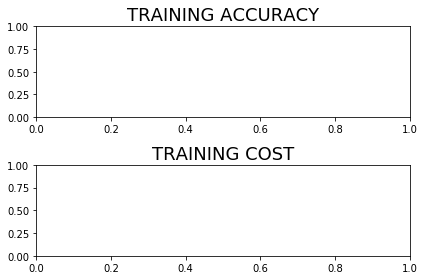

In [12]:
epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

In [13]:
#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={Xtens: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={Xtens: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={Xtens: testX, 
                                                                yGold: testY})))

step 0, training accuracy 0.968072
step 0, cost 4152.1
step 0, change in cost 4152.1
step 10, training accuracy 0.968072
step 10, cost 3953.4
step 10, change in cost 198.692
step 20, training accuracy 0.968072
step 20, cost 3936.84
step 20, change in cost 16.5645
step 30, training accuracy 0.968072
step 30, cost 3931.07
step 30, change in cost 5.77344
step 40, training accuracy 0.968072
step 40, cost 3928.1
step 40, change in cost 2.96484
step 50, training accuracy 0.968072
step 50, cost 3926.23
step 50, change in cost 1.875
step 60, training accuracy 0.968072
step 60, cost 3924.86
step 60, change in cost 1.36377
step 70, training accuracy 0.968072
step 70, cost 3923.77
step 70, change in cost 1.09766
step 80, training accuracy 0.968072
step 80, cost 3922.81
step 80, change in cost 0.951416
step 90, training accuracy 0.968072
step 90, cost 3921.94
step 90, change in cost 0.875244
step 100, training accuracy 0.968072
step 100, cost 3921.1
step 100, change in cost 0.839844
step 110, trai

step 890, training accuracy 0.991896
step 890, cost 1076.54
step 890, change in cost 26.6652
step 900, training accuracy 0.991986
step 900, cost 1052.03
step 900, change in cost 24.5078
step 910, training accuracy 0.992123
step 910, cost 1029.42
step 910, change in cost 22.6099
step 920, training accuracy 0.992221
step 920, cost 1008.48
step 920, change in cost 20.9379
step 930, training accuracy 0.992367
step 930, cost 989.022
step 930, change in cost 19.4575
step 940, training accuracy 0.992489
step 940, cost 970.877
step 940, change in cost 18.1448
step 950, training accuracy 0.992586
step 950, cost 953.904
step 950, change in cost 16.9736
step 960, training accuracy 0.992667
step 960, cost 937.975
step 960, change in cost 15.9283
step 970, training accuracy 0.992732
step 970, cost 922.984
step 970, change in cost 14.9913
step 980, training accuracy 0.992797
step 980, cost 908.835
step 980, change in cost 14.149
step 990, training accuracy 0.992854
step 990, cost 895.446
step 990, c

step 1760, training accuracy 0.995985
step 1760, cost 502.792
step 1760, change in cost 2.31818
step 1770, training accuracy 0.996001
step 1770, cost 500.504
step 1770, change in cost 2.28754
step 1780, training accuracy 0.996017
step 1780, cost 498.246
step 1780, change in cost 2.258
step 1790, training accuracy 0.996025
step 1790, cost 496.017
step 1790, change in cost 2.22925
step 1800, training accuracy 0.99605
step 1800, cost 493.816
step 1800, change in cost 2.20084
step 1810, training accuracy 0.996098
step 1810, cost 491.643
step 1810, change in cost 2.1731
step 1820, training accuracy 0.996123
step 1820, cost 489.497
step 1820, change in cost 2.14569
step 1830, training accuracy 0.996131
step 1830, cost 487.379
step 1830, change in cost 2.11893
step 1840, training accuracy 0.996123
step 1840, cost 485.286
step 1840, change in cost 2.09299
step 1850, training accuracy 0.996155
step 1850, cost 483.219
step 1850, change in cost 2.06699
step 1860, training accuracy 0.996163
step 1

step 2620, training accuracy 0.996845
step 2620, cost 374.828
step 2620, change in cost 0.9758
step 2630, training accuracy 0.996836
step 2630, cost 373.859
step 2630, change in cost 0.96817
step 2640, training accuracy 0.996853
step 2640, cost 372.899
step 2640, change in cost 0.96051
step 2650, training accuracy 0.996869
step 2650, cost 371.946
step 2650, change in cost 0.953033
step 2660, training accuracy 0.996877
step 2660, cost 371
step 2660, change in cost 0.945648
step 2670, training accuracy 0.996869
step 2670, cost 370.062
step 2670, change in cost 0.938568
step 2680, training accuracy 0.996869
step 2680, cost 369.13
step 2680, change in cost 0.931488
step 2690, training accuracy 0.996885
step 2690, cost 368.206
step 2690, change in cost 0.924225
step 2700, training accuracy 0.996901
step 2700, cost 367.289
step 2700, change in cost 0.917267
step 2710, training accuracy 0.996909
step 2710, cost 366.378
step 2710, change in cost 0.910522
step 2720, training accuracy 0.996909
s

step 3470, training accuracy 0.997412
step 3470, cost 312.277
step 3470, change in cost 0.565643
step 3480, training accuracy 0.99742
step 3480, cost 311.714
step 3480, change in cost 0.562592
step 3490, training accuracy 0.99742
step 3490, cost 311.154
step 3490, change in cost 0.559906
step 3500, training accuracy 0.997437
step 3500, cost 310.598
step 3500, change in cost 0.556641
step 3510, training accuracy 0.997437
step 3510, cost 310.044
step 3510, change in cost 0.554047
step 3520, training accuracy 0.997437
step 3520, cost 309.492
step 3520, change in cost 0.551056
step 3530, training accuracy 0.997437
step 3530, cost 308.944
step 3530, change in cost 0.54834
step 3540, training accuracy 0.997437
step 3540, cost 308.399
step 3540, change in cost 0.545502
step 3550, training accuracy 0.997437
step 3550, cost 307.856
step 3550, change in cost 0.542877
step 3560, training accuracy 0.997437
step 3560, cost 307.316
step 3560, change in cost 0.539948
step 3570, training accuracy 0.99

step 4320, training accuracy 0.99768
step 4320, cost 272.837
step 4320, change in cost 0.384003
step 4330, training accuracy 0.997688
step 4330, cost 272.455
step 4330, change in cost 0.382355
step 4340, training accuracy 0.997688
step 4340, cost 272.074
step 4340, change in cost 0.38092
step 4350, training accuracy 0.997688
step 4350, cost 271.695
step 4350, change in cost 0.379089
step 4360, training accuracy 0.997688
step 4360, cost 271.317
step 4360, change in cost 0.377838
step 4370, training accuracy 0.997696
step 4370, cost 270.941
step 4370, change in cost 0.376251
step 4380, training accuracy 0.997696
step 4380, cost 270.566
step 4380, change in cost 0.374695
step 4390, training accuracy 0.997712
step 4390, cost 270.193
step 4390, change in cost 0.373138
step 4400, training accuracy 0.997721
step 4400, cost 269.821
step 4400, change in cost 0.371826
step 4410, training accuracy 0.997721
step 4410, cost 269.451
step 4410, change in cost 0.370361
step 4420, training accuracy 0.9

step 5170, training accuracy 0.997964
step 5170, cost 245.076
step 5170, change in cost 0.278717
step 5180, training accuracy 0.997964
step 5180, cost 244.798
step 5180, change in cost 0.277573
step 5190, training accuracy 0.997964
step 5190, cost 244.522
step 5190, change in cost 0.276627
step 5200, training accuracy 0.997964
step 5200, cost 244.246
step 5200, change in cost 0.275696
step 5210, training accuracy 0.997964
step 5210, cost 243.971
step 5210, change in cost 0.274719
step 5220, training accuracy 0.997972
step 5220, cost 243.697
step 5220, change in cost 0.273727
step 5230, training accuracy 0.997972
step 5230, cost 243.425
step 5230, change in cost 0.272812
step 5240, training accuracy 0.997972
step 5240, cost 243.153
step 5240, change in cost 0.271851
step 5250, training accuracy 0.997972
step 5250, cost 242.882
step 5250, change in cost 0.270874
step 5260, training accuracy 0.997972
step 5260, cost 242.612
step 5260, change in cost 0.27002
step 5270, training accuracy 0.

step 6020, training accuracy 0.998126
step 6020, cost 224.49
step 6020, change in cost 0.211639
step 6030, training accuracy 0.998126
step 6030, cost 224.279
step 6030, change in cost 0.211044
step 6040, training accuracy 0.998126
step 6040, cost 224.069
step 6040, change in cost 0.210388
step 6050, training accuracy 0.998126
step 6050, cost 223.859
step 6050, change in cost 0.209824
step 6060, training accuracy 0.998126
step 6060, cost 223.65
step 6060, change in cost 0.209183
step 6070, training accuracy 0.998126
step 6070, cost 223.442
step 6070, change in cost 0.208481
step 6080, training accuracy 0.998126
step 6080, cost 223.233
step 6080, change in cost 0.208069
step 6090, training accuracy 0.998126
step 6090, cost 223.026
step 6090, change in cost 0.207428
step 6100, training accuracy 0.998126
step 6100, cost 222.819
step 6100, change in cost 0.206665
step 6110, training accuracy 0.998126
step 6110, cost 222.613
step 6110, change in cost 0.206268
step 6120, training accuracy 0.9

step 6870, training accuracy 0.99824
step 6870, cost 208.454
step 6870, change in cost 0.169479
step 6880, training accuracy 0.99824
step 6880, cost 208.285
step 6880, change in cost 0.169037
step 6890, training accuracy 0.99824
step 6890, cost 208.116
step 6890, change in cost 0.168732
step 6900, training accuracy 0.99824
step 6900, cost 207.948
step 6900, change in cost 0.168365
step 6910, training accuracy 0.998248
step 6910, cost 207.78
step 6910, change in cost 0.167938
step 6920, training accuracy 0.998248
step 6920, cost 207.612
step 6920, change in cost 0.167603
step 6930, training accuracy 0.998248
step 6930, cost 207.445
step 6930, change in cost 0.167175
step 6940, training accuracy 0.998256
step 6940, cost 207.278
step 6940, change in cost 0.166779
step 6950, training accuracy 0.998256
step 6950, cost 207.112
step 6950, change in cost 0.166565
step 6960, training accuracy 0.998256
step 6960, cost 206.946
step 6960, change in cost 0.166138
step 6970, training accuracy 0.9982

step 7720, training accuracy 0.998386
step 7720, cost 195.155
step 7720, change in cost 0.148148
step 7730, training accuracy 0.998386
step 7730, cost 195.007
step 7730, change in cost 0.148102
step 7740, training accuracy 0.998386
step 7740, cost 194.859
step 7740, change in cost 0.148102
step 7750, training accuracy 0.998386
step 7750, cost 194.711
step 7750, change in cost 0.148041
step 7760, training accuracy 0.998386
step 7760, cost 194.563
step 7760, change in cost 0.148026
step 7770, training accuracy 0.998386
step 7770, cost 194.415
step 7770, change in cost 0.148102
step 7780, training accuracy 0.998386
step 7780, cost 194.267
step 7780, change in cost 0.147995
step 7790, training accuracy 0.998386
step 7790, cost 194.119
step 7790, change in cost 0.148071
step 7800, training accuracy 0.998386
step 7800, cost 193.971
step 7800, change in cost 0.148163
step 7810, training accuracy 0.998394
step 7810, cost 193.823
step 7810, change in cost 0.148117
step 7820, training accuracy 0

step 8570, training accuracy 0.998645
step 8570, cost 181.493
step 8570, change in cost 0.183762
step 8580, training accuracy 0.998645
step 8580, cost 181.309
step 8580, change in cost 0.183929
step 8590, training accuracy 0.998645
step 8590, cost 181.125
step 8590, change in cost 0.18396
step 8600, training accuracy 0.998645
step 8600, cost 180.941
step 8600, change in cost 0.184052
step 8610, training accuracy 0.998645
step 8610, cost 180.757
step 8610, change in cost 0.184006
step 8620, training accuracy 0.998645
step 8620, cost 180.573
step 8620, change in cost 0.18396
step 8630, training accuracy 0.998645
step 8630, cost 180.389
step 8630, change in cost 0.183746
step 8640, training accuracy 0.998653
step 8640, cost 180.206
step 8640, change in cost 0.183563
step 8650, training accuracy 0.998653
step 8650, cost 180.022
step 8650, change in cost 0.183319
step 8660, training accuracy 0.998653
step 8660, cost 179.84
step 8660, change in cost 0.182831
step 8670, training accuracy 0.99

step 9420, training accuracy 0.998702
step 9420, cost 169.128
step 9420, change in cost 0.10466
step 9430, training accuracy 0.998702
step 9430, cost 169.024
step 9430, change in cost 0.104172
step 9440, training accuracy 0.998702
step 9440, cost 168.92
step 9440, change in cost 0.103455
step 9450, training accuracy 0.99871
step 9450, cost 168.817
step 9450, change in cost 0.102966
step 9460, training accuracy 0.99871
step 9460, cost 168.715
step 9460, change in cost 0.102448
step 9470, training accuracy 0.99871
step 9470, cost 168.613
step 9470, change in cost 0.101883
step 9480, training accuracy 0.99871
step 9480, cost 168.512
step 9480, change in cost 0.101364
step 9490, training accuracy 0.99871
step 9490, cost 168.411
step 9490, change in cost 0.100891
step 9500, training accuracy 0.99871
step 9500, cost 168.31
step 9500, change in cost 0.100388
step 9510, training accuracy 0.99871
step 9510, cost 168.211
step 9510, change in cost 0.0998077
step 9520, training accuracy 0.99871
st

step 10260, training accuracy 0.998743
step 10260, cost 161.696
step 10260, change in cost 0.0774689
step 10270, training accuracy 0.998743
step 10270, cost 161.619
step 10270, change in cost 0.0773163
step 10280, training accuracy 0.998743
step 10280, cost 161.542
step 10280, change in cost 0.077179
step 10290, training accuracy 0.998743
step 10290, cost 161.465
step 10290, change in cost 0.0769348
step 10300, training accuracy 0.998743
step 10300, cost 161.388
step 10300, change in cost 0.076767
step 10310, training accuracy 0.998743
step 10310, cost 161.311
step 10310, change in cost 0.0765228
step 10320, training accuracy 0.998743
step 10320, cost 161.235
step 10320, change in cost 0.076355
step 10330, training accuracy 0.998743
step 10330, cost 161.159
step 10330, change in cost 0.0761261
step 10340, training accuracy 0.998743
step 10340, cost 161.083
step 10340, change in cost 0.0759583
step 10350, training accuracy 0.998743
step 10350, cost 161.007
step 10350, change in cost 0.0

step 11080, training accuracy 0.998775
step 11080, cost 155.911
step 11080, change in cost 0.0646667
step 11090, training accuracy 0.998775
step 11090, cost 155.847
step 11090, change in cost 0.0645447
step 11100, training accuracy 0.998775
step 11100, cost 155.782
step 11100, change in cost 0.0644226
step 11110, training accuracy 0.998775
step 11110, cost 155.718
step 11110, change in cost 0.0642853
step 11120, training accuracy 0.998775
step 11120, cost 155.654
step 11120, change in cost 0.0641785
step 11130, training accuracy 0.998775
step 11130, cost 155.59
step 11130, change in cost 0.0639648
step 11140, training accuracy 0.998775
step 11140, cost 155.526
step 11140, change in cost 0.0638885
step 11150, training accuracy 0.998775
step 11150, cost 155.462
step 11150, change in cost 0.0637817
step 11160, training accuracy 0.998783
step 11160, cost 155.398
step 11160, change in cost 0.0636597
step 11170, training accuracy 0.998783
step 11170, cost 155.335
step 11170, change in cost 0

step 11900, training accuracy 0.998824
step 11900, cost 151.001
step 11900, change in cost 0.0556641
step 11910, training accuracy 0.998824
step 11910, cost 150.945
step 11910, change in cost 0.0555267
step 11920, training accuracy 0.998824
step 11920, cost 150.89
step 11920, change in cost 0.0554657
step 11930, training accuracy 0.998824
step 11930, cost 150.835
step 11930, change in cost 0.0553589
step 11940, training accuracy 0.998824
step 11940, cost 150.779
step 11940, change in cost 0.0552826
step 11950, training accuracy 0.998824
step 11950, cost 150.724
step 11950, change in cost 0.055191
step 11960, training accuracy 0.998824
step 11960, cost 150.669
step 11960, change in cost 0.055069
step 11970, training accuracy 0.998824
step 11970, cost 150.614
step 11970, change in cost 0.0549927
step 11980, training accuracy 0.998824
step 11980, cost 150.559
step 11980, change in cost 0.0549011
step 11990, training accuracy 0.998824
step 11990, cost 150.504
step 11990, change in cost 0.0

step 12720, training accuracy 0.998848
step 12720, cost 146.735
step 12720, change in cost 0.0487671
step 12730, training accuracy 0.998848
step 12730, cost 146.686
step 12730, change in cost 0.0486755
step 12740, training accuracy 0.998848
step 12740, cost 146.638
step 12740, change in cost 0.048645
step 12750, training accuracy 0.998848
step 12750, cost 146.589
step 12750, change in cost 0.0484772
step 12760, training accuracy 0.998848
step 12760, cost 146.541
step 12760, change in cost 0.0484467
step 12770, training accuracy 0.998848
step 12770, cost 146.492
step 12770, change in cost 0.0484314
step 12780, training accuracy 0.998848
step 12780, cost 146.444
step 12780, change in cost 0.0482941
step 12790, training accuracy 0.998848
step 12790, cost 146.396
step 12790, change in cost 0.0482025
step 12800, training accuracy 0.998848
step 12800, cost 146.348
step 12800, change in cost 0.048172
step 12810, training accuracy 0.998856
step 12810, cost 146.3
step 12810, change in cost 0.04

step 13540, training accuracy 0.998872
step 13540, cost 142.974
step 13540, change in cost 0.0432739
step 13550, training accuracy 0.998872
step 13550, cost 142.931
step 13550, change in cost 0.0431519
step 13560, training accuracy 0.998872
step 13560, cost 142.888
step 13560, change in cost 0.0431213
step 13570, training accuracy 0.998872
step 13570, cost 142.844
step 13570, change in cost 0.0430756
step 13580, training accuracy 0.998872
step 13580, cost 142.801
step 13580, change in cost 0.0430145
step 13590, training accuracy 0.998872
step 13590, cost 142.759
step 13590, change in cost 0.0429688
step 13600, training accuracy 0.998872
step 13600, cost 142.716
step 13600, change in cost 0.0428619
step 13610, training accuracy 0.998872
step 13610, cost 142.673
step 13610, change in cost 0.0428314
step 13620, training accuracy 0.998872
step 13620, cost 142.63
step 13620, change in cost 0.0428162
step 13630, training accuracy 0.998872
step 13630, cost 142.587
step 13630, change in cost 0

KeyboardInterrupt: 

In [14]:
# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={Xtens: testX,
                                                                yGold: testY})))

final accuracy on test set: 0.998435


In [15]:
y_res = sess.run(activation_OP, feed_dict={Xtens:testX})

In [16]:
y_res

array([[  5.77938859e-04,   9.98627782e-01],
       [  5.25217911e-06,   9.99793470e-01],
       [  2.57407140e-04,   9.99964118e-01],
       ..., 
       [  2.05359302e-05,   9.99968648e-01],
       [  1.63934268e-02,   9.88649011e-01],
       [  4.09546017e-04,   9.99468982e-01]], dtype=float32)

In [17]:
y_res = list(y_res[:,0] > 0.5)

In [18]:
y_gold = list(bool(yy) for yy in testY[:,0])

In [19]:
acc = [(ref, pred) for ref, pred in zip(y_gold, y_res)]
c = Counter(acc)
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

Counter({(False, False): 58835, (True, True): 1787, (True, False): 88, (False, True): 10})
Spam->Spam: 0.9531
Ham -> Ham: 0.9998
Accuracy: 0.9984


In [26]:
acc = [idx for ref, pred, idx in zip(y_gold, y_res, tsX_idx) if (ref, pred) == (False, True)]
spammy_stuff = [(data[idx]['recid'], data[idx]['description']) for idx in acc]

In [27]:
spammy_stuff

[(345850, '<p>Chapter two complete</p>'),
 (46723,
  '<p>You can now opt between <a href="https://github.com/eriqande/gsi_sim">gsi_sim</a> or <a href="https://github.com/thibautjombart/adegenet">adegenet</a>, a R package developed by Thibaul Jombart, to conduct the assignment analysis</p>'),
 (34237, '<p>Progress report for the week ending 20-11-2015</p>'),
 (438684,
  'Project in OR: The assignment problem\n<p>A java implementation for the assignment problem first release</p>'),
 (13756,
  '<p>Tutorial for self directed bootcamp for learning R-programming basics.</p>\n\n<p>Each folder contains a different module. Each folder contains a file, ex. &quot;module1.R&quot; that is meant to be loaded as a script into an IDE such as RStudio. By working through the script, basic concepts of R and its data structures are taught.</p>\n\n<p>The content of each module is as follows:</p>\n\n<ol>\n<li>Getting Help, Loading, Saving, Data QC, Scripting</li>\n<li>Vectors, Data Frames, Subsetting, Filte

In [20]:
# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
saver.save(sess, "trained_variables.ckpt")

# Close tensorflow session
#sess.close()

'trained_variables.ckpt'